# Import

In [1]:
import os
import sys

import time
import math
import json
import glob
from datetime import datetime

import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize, least_squares
import matplotlib.pyplot as plt

import cv2
import torch
from torch.nn.functional import mse_loss
from pytorch_kinematics.transforms.rotation_conversions import matrix_to_axis_angle, axis_angle_to_matrix

import pytorch_kinematics as pk
from pytransform3d.urdf import UrdfTransformManager
from urdf_parser_py.urdf import URDF

# Helper Functions

In [2]:
def load_json(filename: str):
    # Construct the absolute path by joining the current directory and relative path
    absolute_path = os.path.join(os.getcwd(), '..', filename)
    # Load the JSON data
    with open(absolute_path, 'r') as file:
        json_data = json.load(file)    
    return json_data

def xml_to_str(robot):
    # To XML string with filtering
    temp_str = robot.to_xml_string()
    words = temp_str.split()
    words[5] = '>'
    urdf_str = ' '.join(words)
    return urdf_str

def forward_kinematics(V, 
                       cmd_lnt, cmd_lnp, cmd_unt, cmd_et, cmd_lep, cmd_rep,
                       l_rvec, l_tvec, r_rvec, r_tvec):
    
    # Convert to Tensor
    cmd_lnt = torch.Tensor(cmd_lnt).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_lnp = torch.Tensor(cmd_lnp).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_unt = torch.Tensor(cmd_unt).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_et = torch.Tensor(cmd_et).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_lep = torch.Tensor(cmd_lep).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_rep = torch.Tensor(cmd_rep).reshape(-1,1).to(dtype=dtype, device=device)

    l_rvec_t = torch.Tensor(l_rvec).to(dtype=dtype, device=device)
    l_tvec_t = torch.Tensor(l_tvec).to(dtype=dtype, device=device)
    r_rvec_t = torch.Tensor(r_rvec).to(dtype=dtype, device=device)
    r_tvec_t = torch.Tensor(r_tvec).to(dtype=dtype, device=device)

    #Joint-to-Motor Polynomial Models
    neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt @ torch.Tensor([V[var2idx['neck_pitch_polyfit_b1']]]).to(dtype=dtype, device=device)
    neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp @ torch.Tensor([V[var2idx['neck_yaw_polyfit_b1']]]).to(dtype=dtype, device=device)
    head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt @ torch.Tensor([V[var2idx['head_pitch_polyfit_b1']]]).to(dtype=dtype, device=device)
    eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et @ torch.Tensor([V[var2idx['eyes_pitch_polyfit_b1']]]).to(dtype=dtype, device=device)
    lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep @ torch.Tensor([V[var2idx['lefteye_yaw_polyfit_b1']]]).to(dtype=dtype, device=device)
    righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep @ torch.Tensor([V[var2idx['righteye_yaw_polyfit_b1']]]).to(dtype=dtype, device=device)

    # URDF Variable Assignment
    for joint in robot.joints:
        if joint.name == 'torso':
            joint.origin.position[0] = V[var2idx['torso_origin_x']]
            joint.origin.position[1] = V[var2idx['torso_origin_y']]
            joint.origin.position[2] = V[var2idx['torso_origin_z']]
        elif joint.name == 'neck_pitch':
            joint.origin.rotation[0] = V[var2idx['neck_pitch_rot_r']]
        elif joint.name == 'head_pitch':
            joint.origin.position[2] = V[var2idx['head_pitch_origin_z']]
        elif joint.name == 'eyes_pitch':
            joint.origin.position[0] = V[var2idx['eyes_pitch_origin_x']]
            joint.origin.position[2] = V[var2idx['eyes_pitch_origin_z']]
        elif joint.name == 'lefteye_yaw':
            joint.origin.position[1] = V[var2idx['lefteye_yaw_origin_y']]
        elif joint.name == 'righteye_yaw':
            joint.origin.position[1] = -V[var2idx['lefteye_yaw_origin_y']]
        elif joint.name == 'lefteye_cam':
            joint.origin.position[0] = V[var2idx['lefteye_cam_origin_x']]
            joint.origin.rotation[0] = V[var2idx['lefteye_cam_rot_r']]
            joint.origin.rotation[2] = V[var2idx['lefteye_cam_rot_y']]
        elif joint.name == 'righteye_cam':
            joint.origin.position[0] = V[var2idx['righteye_cam_origin_x']]
            joint.origin.rotation[0] = V[var2idx['righteye_cam_rot_r']]
            joint.origin.rotation[2] = V[var2idx['righteye_cam_rot_y']]
    
    # XML to String
    urdf_str = xml_to_str(robot)
    
    # Kinematic Chain
    chain = pk.build_chain_from_urdf(urdf_str)
    chain.to(dtype=dtype, device=device)
    
    # Specifying Joint Angles (radians)
    joint_cmd = torch.cat((neck_pitch.reshape(-1,1), neck_yaw.reshape(-1,1), head_pitch.reshape(-1,1), eyes_pitch.reshape(-1,1), lefteye_yaw.reshape(-1,1), righteye_yaw.reshape(-1,1)), dim=1)

    # Forward Kinematics
    ret = chain.forward_kinematics(joint_cmd)

    # Realsense to Left Eye Camera (Pytorch) with Points
    T_clprime = torch.linalg.inv(ret['leftcamera'].get_matrix()) @ ret['realsense'].get_matrix()
    
    # Realsense to Right Eye Camera (Pytorch) with Points
    T_crprime = torch.linalg.inv(ret['rightcamera'].get_matrix()) @ ret['realsense'].get_matrix()

    # Rvec and Tvec
    out_l_rvec = matrix_to_axis_angle(T_clprime[:,:3,:3])
    out_l_tvec = T_clprime[:,:3,3]
    out_r_rvec = matrix_to_axis_angle(T_crprime[:,:3,:3])
    out_r_tvec = T_crprime[:,:3,3]

    # Return Output
    return out_l_rvec, out_l_tvec, out_r_rvec, out_r_rvec, out_r_tvec

# Initialization

In [3]:
# Explicitly telling to use GPU
torch.set_default_device('cuda')
torch.set_default_dtype(d=torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float64

In [4]:
# Load Configs
cam_mtxs = load_json('camera_mtx.json')
gaze_ctrs = load_json('calib_params.json')
urdf_path = os.path.join(os.getcwd(),"..","urdf","chest_grace_cam_true.urdf")
robot = URDF.from_xml_file(urdf_path)

## Load Dataset

In [5]:
# Load Dataset CSV

data_fn = "241003_075m_grace_dataset.csv"
data_dir = "final"
csv_file = os.path.join(os.getcwd(),"..","data", data_dir, data_fn)
temp_df = pd.read_csv(csv_file)
print(temp_df.shape)

(71552, 32)


In [6]:
# Convert DF Degrees Column to Radians
data_df = temp_df.copy()
data_df['cmd_theta_lower_neck_pan'] = np.radians(data_df['cmd_theta_lower_neck_pan'].values)
data_df['cmd_theta_lower_neck_tilt'] = np.radians(data_df['cmd_theta_lower_neck_tilt'].values)
data_df['cmd_theta_upper_neck_tilt'] = np.radians(data_df['cmd_theta_upper_neck_tilt'].values)
data_df['cmd_theta_left_eye_pan'] = np.radians(data_df['cmd_theta_left_eye_pan'].values)
data_df['cmd_theta_right_eye_pan'] = np.radians(data_df['cmd_theta_right_eye_pan'].values)
data_df['cmd_theta_eyes_tilt'] = np.radians(data_df['cmd_theta_eyes_tilt'].values)

## Load Optimization Results

In [7]:
# Load CSV Optimization Results

csv_fn = "20241003_055157_467129_075m_grace_results.csv"
csv_path = os.path.join(os.getcwd(),"..","results",csv_fn)
df = pd.read_csv(csv_path, index_col=0)
var_dict = dict(zip(df.index,df['learned'].values))
var_dict

{'neck_pitch_polyfit_b0': 0.1612020500485917,
 'neck_yaw_polyfit_b0': 0.0251609138387474,
 'head_pitch_polyfit_b0': 0.0753431266873075,
 'eyes_pitch_polyfit_b0': 0.0870086257485741,
 'lefteye_yaw_polyfit_b0': 0.0654077723982631,
 'righteye_yaw_polyfit_b0': -0.0597188167813513,
 'neck_pitch_polyfit_b1': 0.4428986196092834,
 'neck_yaw_polyfit_b1': 0.8887165804783272,
 'head_pitch_polyfit_b1': 0.5408634890593448,
 'eyes_pitch_polyfit_b1': 0.3842083656197665,
 'lefteye_yaw_polyfit_b1': 1.4713116955969434,
 'righteye_yaw_polyfit_b1': 1.606848729740859,
 'neck_pitch_rot_r': -0.0362074249775013,
 'torso_origin_x': 0.0374645119251452,
 'torso_origin_y': -0.0667661231939572,
 'torso_origin_z': -0.1215767337652976,
 'head_pitch_origin_z': 0.1183379364757624,
 'eyes_pitch_origin_x': 0.0899945240403851,
 'eyes_pitch_origin_z': 0.0377774221479293,
 'lefteye_yaw_origin_y': 0.0348723466969864,
 'lefteye_cam_origin_x': 0.0257853359996904,
 'righteye_cam_origin_x': 0.0265308762030316,
 'lefteye_cam_rot

In [8]:
# Decision Variables 
var_list = list(var_dict.values())

# Variable Names
var_names_list = list(var_dict.keys())

# Mapping
idx2var = dict(zip(list(range(len(var_names_list))),var_names_list))
var2idx = dict(zip(var_names_list, list(range(len(var_names_list)))))

# Evaluation

In [9]:
# Input

V = np.array(var_list)
x_c_l = data_df['x_c_l'].to_numpy()
y_c_l = data_df['y_c_l'].to_numpy()
z_c_l = data_df['z_c_l'].to_numpy()
x_c_r = data_df['x_c_r'].to_numpy()
y_c_r = data_df['y_c_r'].to_numpy()
z_c_r = data_df['z_c_r'].to_numpy()
cmd_lnt = data_df['cmd_theta_lower_neck_tilt'].to_numpy()
cmd_lnp = data_df['cmd_theta_lower_neck_pan'].to_numpy()
cmd_unt = data_df['cmd_theta_upper_neck_tilt'].to_numpy()
cmd_et = data_df['cmd_theta_eyes_tilt'].to_numpy()
cmd_lep = data_df['cmd_theta_left_eye_pan'].to_numpy()
cmd_rep = data_df['cmd_theta_right_eye_pan'].to_numpy()

l_rvec = np.concatenate([data_df['l_rvec_0'].values.reshape(-1,1),
                         data_df['l_rvec_1'].values.reshape(-1,1),
                         data_df['l_rvec_2'].values.reshape(-1,1)], axis=1)
l_tvec = np.concatenate([data_df['l_tvec_0'].values.reshape(-1,1),
                         data_df['l_tvec_1'].values.reshape(-1,1),
                         data_df['l_tvec_2'].values.reshape(-1,1)], axis=1)
r_rvec = np.concatenate([data_df['r_rvec_0'].values.reshape(-1,1),
                         data_df['r_rvec_1'].values.reshape(-1,1),
                         data_df['r_rvec_2'].values.reshape(-1,1)], axis=1)
r_tvec = np.concatenate([data_df['r_tvec_0'].values.reshape(-1,1),
                         data_df['r_tvec_1'].values.reshape(-1,1),
                         data_df['r_tvec_2'].values.reshape(-1,1)], axis=1)

In [10]:
# Fprward Kinematics

out_l_rvec, out_l_tvec, out_r_rvec, out_r_rvec, out_r_tvec = forward_kinematics(V, 
                                                                                cmd_lnt, cmd_lnp, cmd_unt, cmd_et, cmd_lep, cmd_rep,
                                                                                l_rvec, l_tvec, r_rvec, r_tvec)

In [11]:
# True Value

l_rvec_t = torch.Tensor(l_rvec).to(dtype=dtype, device=device)
l_tvec_t = torch.Tensor(l_tvec).to(dtype=dtype, device=device)
r_rvec_t = torch.Tensor(r_rvec).to(dtype=dtype, device=device)
r_tvec_t = torch.Tensor(r_tvec).to(dtype=dtype, device=device)

## Results

In [12]:
# Results

results_idx = ['r(rad)','p(rad)', 'y(rad)', 'x(mm)','y(mm)', 'z(mm)',]
results_df = pd.DataFrame({'Left Eye MSE': [
                            mse_loss(out_l_rvec[:,0], l_rvec_t[:,0]).cpu().item(),
                            mse_loss(out_l_rvec[:,1], l_rvec_t[:,1]).cpu().item(),
                            mse_loss(out_l_rvec[:,2], l_rvec_t[:,2]).cpu().item(),
                            mse_loss(1000*out_l_tvec[:,0], 1000*l_tvec_t[:,0]).cpu().item(),
                            mse_loss(1000*out_l_tvec[:,1], 1000*l_tvec_t[:,1]).cpu().item(),
                            mse_loss(1000*out_l_tvec[:,2], 1000*l_tvec_t[:,2]).cpu().item(),
                            ],
                          'Right Eye MSE': [
                            mse_loss(out_r_rvec[:,0], r_rvec_t[:,0]).cpu().item(),
                            mse_loss(out_r_rvec[:,1], r_rvec_t[:,1]).cpu().item(),
                            mse_loss(out_r_rvec[:,2], r_rvec_t[:,2]).cpu().item(),
                            mse_loss(1000*out_r_tvec[:,0], 1000*r_tvec_t[:,0]).cpu().item(),
                            mse_loss(1000*out_r_tvec[:,1], 1000*r_tvec_t[:,1]).cpu().item(),
                            mse_loss(1000*out_r_tvec[:,2], 1000*r_tvec_t[:,2]).cpu().item(),
                          ],
                           'Left Eye RMSE': [
                            math.sqrt(mse_loss(out_l_rvec[:,0], l_rvec_t[:,0]).cpu().item()),
                            math.sqrt(mse_loss(out_l_rvec[:,1], l_rvec_t[:,1]).cpu().item()),
                            math.sqrt(mse_loss(out_l_rvec[:,2], l_rvec_t[:,2]).cpu().item()),
                            math.sqrt(mse_loss(1000*out_l_tvec[:,0], 1000*l_tvec_t[:,0]).cpu().item()),
                            math.sqrt(mse_loss(1000*out_l_tvec[:,1], 1000*l_tvec_t[:,1]).cpu().item()),
                            math.sqrt(mse_loss(1000*out_l_tvec[:,2], 1000*l_tvec_t[:,2]).cpu().item()),
                            ],
                          'Right Eye RMSE': [
                            math.sqrt(mse_loss(out_r_rvec[:,0], r_rvec_t[:,0]).cpu().item()),
                            math.sqrt(mse_loss(out_r_rvec[:,1], r_rvec_t[:,1]).cpu().item()),
                            math.sqrt(mse_loss(out_r_rvec[:,2], r_rvec_t[:,2]).cpu().item()),
                            math.sqrt(mse_loss(1000*out_r_tvec[:,0], 1000*r_tvec_t[:,0]).cpu().item()),
                            math.sqrt(mse_loss(1000*out_r_tvec[:,1], 1000*r_tvec_t[:,1]).cpu().item()),
                            math.sqrt(mse_loss(1000*out_r_tvec[:,2], 1000*r_tvec_t[:,2]).cpu().item()),
                          ],
                           
                          })
results_df.index = results_idx
results_df

,Left Eye MSE,Right Eye MSE,Left Eye RMSE,Right Eye RMSE
r(rad),0.000089,0.000089,0.009435,0.009434
p(rad),0.000192,0.000182,0.013857,0.013501
y(rad),0.000080,0.000087,0.008963,0.009301
x(mm),13.881064,25.354186,3.725730,5.035294
y(mm),11.884431,13.141303,3.447380,3.625094
z(mm),5.382377,7.170307,2.319995,2.677743


# Absolute Error

## Absolute Error

In [13]:
temp_df['err_l_rvec_0'] = (out_l_rvec[:,0]-l_rvec_t[:,0]).cpu().numpy()
temp_df['err_l_rvec_1'] = (out_l_rvec[:,1]-l_rvec_t[:,1]).cpu().numpy()
temp_df['err_l_rvec_2'] = (out_l_rvec[:,2]-l_rvec_t[:,2]).cpu().numpy()
temp_df['err_l_tvec_0'] = (out_l_tvec[:,0]-l_tvec_t[:,0]).cpu().numpy()
temp_df['err_l_tvec_1'] = (out_l_tvec[:,1]-l_tvec_t[:,1]).cpu().numpy()
temp_df['err_l_tvec_2'] = (out_l_tvec[:,2]-l_tvec_t[:,2]).cpu().numpy()

temp_df['err_r_rvec_0'] = (out_r_rvec[:,0]-r_rvec_t[:,0]).cpu().numpy()
temp_df['err_r_rvec_1'] = (out_r_rvec[:,1]-r_rvec_t[:,1]).cpu().numpy()
temp_df['err_r_rvec_2'] = (out_r_rvec[:,2]-r_rvec_t[:,2]).cpu().numpy()
temp_df['err_r_tvec_0'] = (out_r_tvec[:,0]-r_tvec_t[:,0]).cpu().numpy()
temp_df['err_r_tvec_1'] = (out_r_tvec[:,1]-r_tvec_t[:,1]).cpu().numpy()
temp_df['err_r_tvec_2'] = (out_r_tvec[:,2]-r_tvec_t[:,2]).cpu().numpy()

print(temp_df.shape)
temp_df.head()

(71552, 44)


,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,...,err_l_rvec_2,err_l_tvec_0,err_l_tvec_1,err_l_tvec_2,err_r_rvec_0,err_r_rvec_1,err_r_rvec_2,err_r_tvec_0,err_r_tvec_1,err_r_tvec_2
0,-0.873669,-0.334702,0.738088,-1.166921,-0.352033,0.738508,-35,-10,-10,-14,...,0.009612,0.002852,-0.004182,-0.001081,-0.015717,-0.034794,-0.001367,-0.000759,-0.002420,-0.000168
1,-0.821681,-0.331576,0.738000,-0.997318,-0.340332,0.738221,-35,-10,-10,-12,...,0.007765,0.003800,-0.005744,-0.000880,-0.017315,-0.017852,-0.002889,-0.002319,-0.004192,-0.001265
2,-0.731501,-0.324165,0.738176,-0.868484,-0.332085,0.738360,-35,-10,-10,-10,...,0.009216,0.001037,-0.005500,-0.000547,-0.018572,-0.007283,-0.002107,-0.003341,-0.004530,-0.001705
3,-0.672994,-0.320809,0.737795,-0.776648,-0.327031,0.737932,-35,-10,-10,-8,...,0.010261,0.002173,-0.004426,0.000303,-0.017353,-0.007904,-0.000962,-0.004996,-0.003348,-0.002194
4,-0.613507,-0.317492,0.737656,-0.690487,-0.321762,0.737752,-35,-10,-10,-6,...,0.011517,0.000767,-0.004813,-0.000808,-0.017716,-0.004645,0.000029,-0.007213,-0.003323,-0.003322


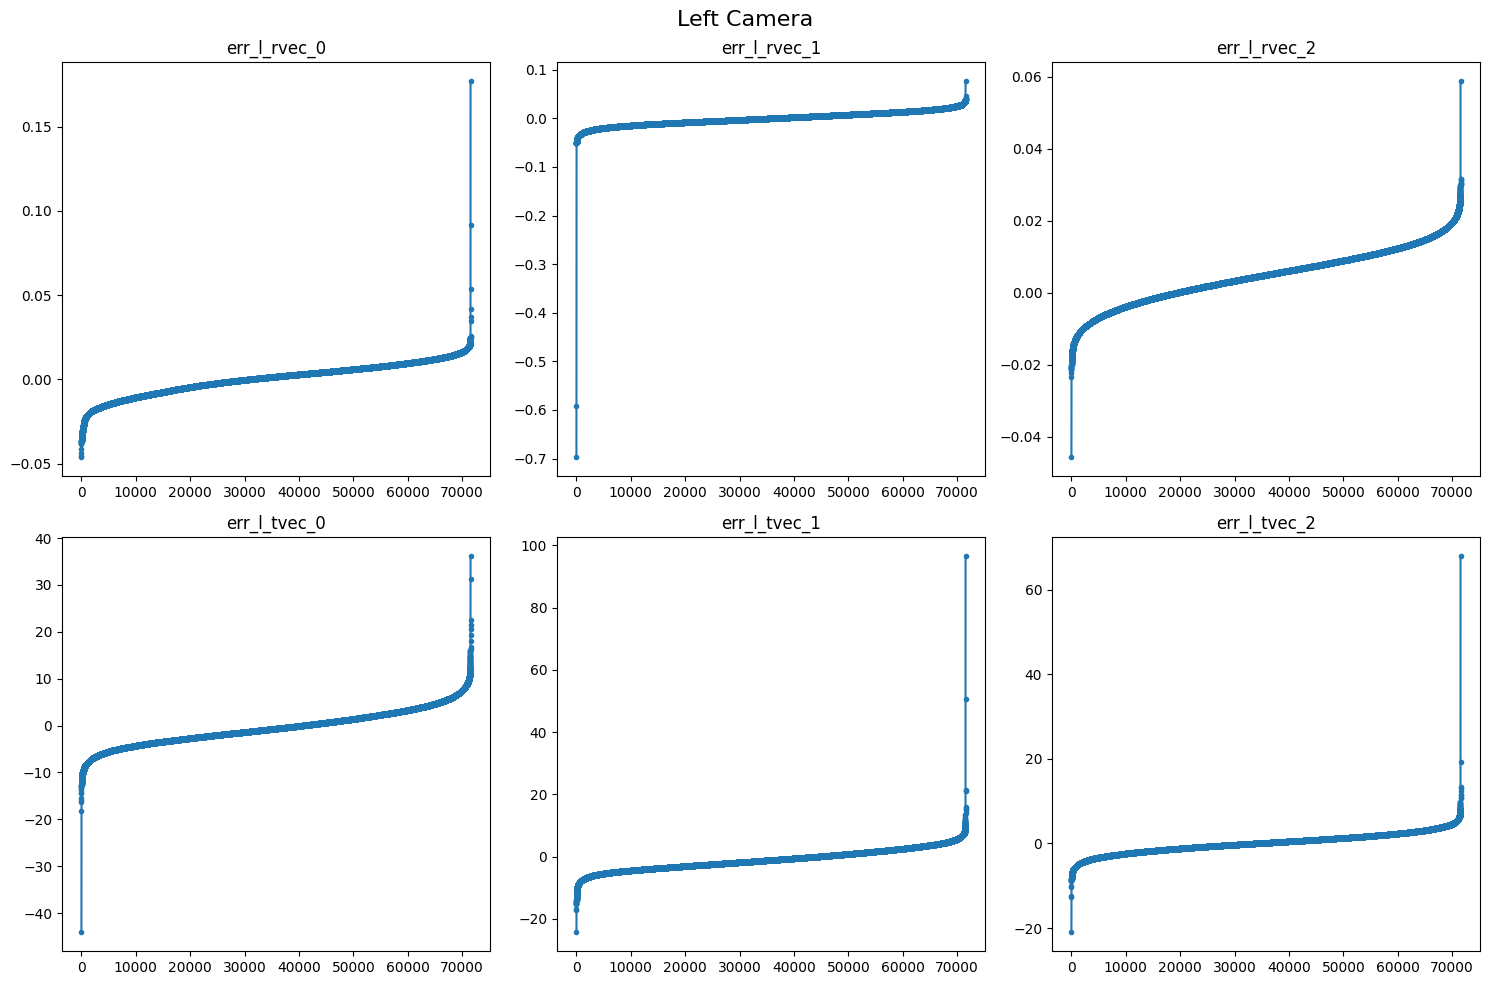

In [14]:
# Create a 2x3 subplot
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plotting
axs[0,0].plot(np.sort(temp_df['err_l_rvec_0']), marker='.')
axs[0,0].set_title('err_l_rvec_0')
axs[0,1].plot(np.sort(temp_df['err_l_rvec_1']), marker='.')
axs[0,1].set_title('err_l_rvec_1')
axs[0,2].plot(np.sort(temp_df['err_l_rvec_2']), marker='.')
axs[0,2].set_title('err_l_rvec_2')

axs[1,0].plot(1000*np.sort(temp_df['err_l_tvec_0']), marker='.')
axs[1,0].set_title('err_l_tvec_0')
axs[1,1].plot(1000*np.sort(temp_df['err_l_tvec_1']), marker='.')
axs[1,1].set_title('err_l_tvec_1')
axs[1,2].plot(1000*np.sort(temp_df['err_l_tvec_2']), marker='.')
axs[1,2].set_title('err_l_tvec_2')

# for i in range(2):
#     for j in range(3):
#         axs[i, j].set_ylim(-1.5, 1.5)

# Adjust layout
fig.suptitle('Left Camera', fontsize=16)
plt.tight_layout()
plt.show()

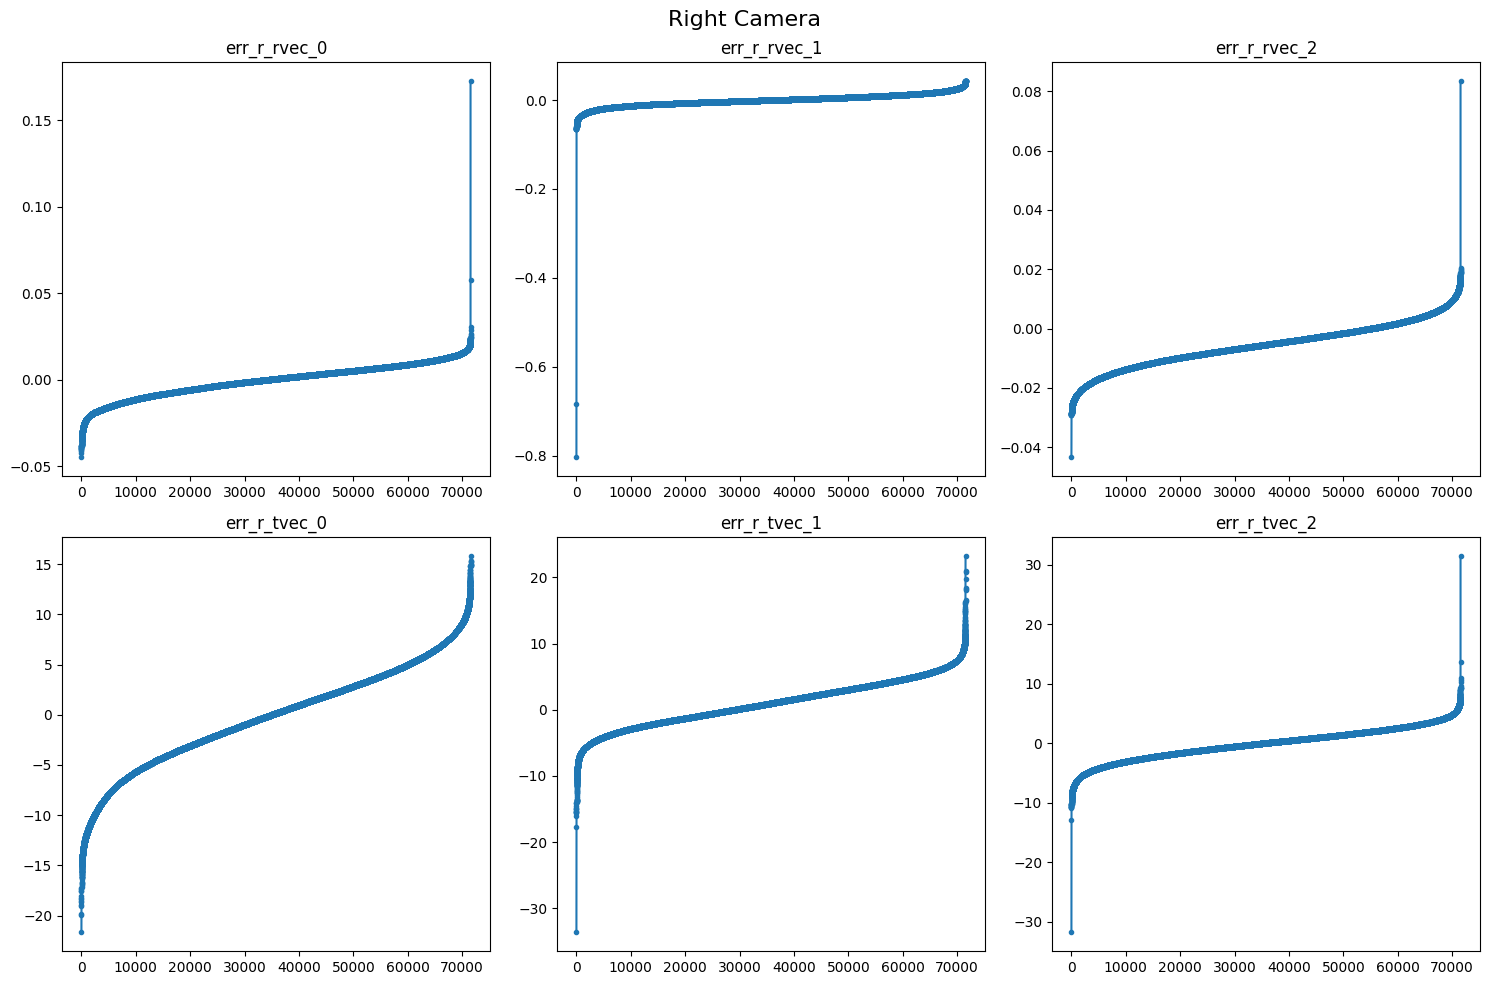

In [15]:
# Create a 2x3 subplot
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plotting
axs[0,0].plot(np.sort(temp_df['err_r_rvec_0']), marker='.')
axs[0,0].set_title('err_r_rvec_0')
axs[0,1].plot(np.sort(temp_df['err_r_rvec_1']), marker='.')
axs[0,1].set_title('err_r_rvec_1')
axs[0,2].plot(np.sort(temp_df['err_r_rvec_2']), marker='.')
axs[0,2].set_title('err_r_rvec_2')

axs[1,0].plot(1000*np.sort(temp_df['err_r_tvec_0']), marker='.')
axs[1,0].set_title('err_r_tvec_0')
axs[1,1].plot(1000*np.sort(temp_df['err_r_tvec_1']), marker='.')
axs[1,1].set_title('err_r_tvec_1')
axs[1,2].plot(1000*np.sort(temp_df['err_r_tvec_2']), marker='.')
axs[1,2].set_title('err_r_tvec_2')

# for i in range(2):
#     for j in range(3):
#         axs[i, j].set_ylim(-1.5, 1.5)

# Adjust layout
fig.suptitle('Right Camera', fontsize=16)
plt.tight_layout()
plt.show()

In [16]:
# Total Absolute Error

temp_df['l_total_abs_err'] = (np.abs(temp_df['err_l_rvec_0']) + np.abs(temp_df['err_l_rvec_1']) + np.abs(temp_df['err_l_rvec_2'])
                           + np.abs(temp_df['err_l_tvec_0']) + np.abs(temp_df['err_l_tvec_1']) + np.abs(temp_df['err_l_tvec_2']))
temp_df['r_total_abs_err'] = (np.abs(temp_df['err_r_rvec_0']) + np.abs(temp_df['err_r_rvec_1']) + np.abs(temp_df['err_r_rvec_2'])
                           + np.abs(temp_df['err_r_tvec_0']) + np.abs(temp_df['err_r_tvec_1']) + np.abs(temp_df['err_r_tvec_2']))  

In [17]:
# Sort Based on Max Error (Descending)

pd.set_option('display.max_columns', None)
sorted_df = temp_df.sort_values(by='l_total_abs_err', ascending=False)
sorted_df[:20]

,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,cmd_theta_right_eye_pan,cmd_theta_eyes_tilt,state_theta_lower_neck_pan,state_theta_left_lower_neck_tilt,state_theta_right_lower_neck_tilt,state_theta_left_upper_neck_tilt,state_theta_right_upper_neck_tilt,state_theta_left_eye,state_theta_right_eye,state_theta_tilt,l_rvec_0,l_rvec_1,l_rvec_2,l_tvec_0,l_tvec_1,l_tvec_2,r_rvec_0,r_rvec_1,r_rvec_2,r_tvec_0,r_tvec_1,r_tvec_2,err_l_rvec_0,err_l_rvec_1,err_l_rvec_2,err_l_tvec_0,err_l_tvec_1,err_l_tvec_2,err_r_rvec_0,err_r_rvec_1,err_r_rvec_2,err_r_tvec_0,err_r_tvec_1,err_r_tvec_2,l_total_abs_err,r_total_abs_err
17279,-0.920876,-0.321250,0.794532,-1.317918,-0.366502,0.818541,-35,10,0,8,8,-5,-34.189453,10.546875,-10.546875,-0.087891,0.000000,-16.171875,-17.314453,21.972656,-0.095652,1.016817,-0.121042,0.042577,0.205573,-0.072462,-0.111982,0.773587,-0.119931,-0.003328,0.202134,-0.050355,0.177030,-0.590964,0.058729,0.016820,-0.003381,0.067913,0.172809,-0.683488,0.083519,-0.002518,-0.000707,0.031497,0.914837,0.974538
13147,-0.349106,-0.384859,0.737127,-0.487764,-0.385468,0.737231,-10,-10,0,14,14,10,-9.843750,-9.228516,9.580078,-0.087891,0.000000,-15.908203,-17.226562,22.060547,-0.234984,0.594948,0.046687,-0.003941,0.222344,-0.056703,-0.263044,0.350700,0.031645,-0.048868,0.222423,-0.045650,0.053737,-0.697754,-0.045774,0.012080,-0.001604,0.019167,0.057557,-0.804357,-0.043432,0.010898,-0.004942,-0.031821,0.830115,0.953008
62668,-0.490555,-0.685182,0.741651,-0.567332,-0.707707,0.741909,-30,0,40,-6,-6,10,-29.179688,0.351562,-0.263672,39.902344,-40.078125,-6.328125,-5.976562,10.107422,-0.578089,0.727167,-0.073490,-0.009952,0.133722,-0.102013,-0.490598,0.381360,-0.142270,-0.000656,0.227739,-0.116227,0.091388,-0.033929,-0.010486,0.036146,0.096536,-0.021029,-0.001369,0.010762,-0.006902,-0.006223,-0.000103,-0.001603,0.289514,0.026962
64760,-0.421900,-0.348502,0.766705,-0.482769,-0.366056,0.770530,-30,10,40,-4,-4,-25,-29.179688,10.546875,-10.458984,39.814453,-39.990234,-4.306641,-3.955078,-24.521484,-0.206577,0.675227,-0.083400,0.015046,0.184824,-0.055695,-0.168247,0.327945,-0.094798,-0.003683,0.235920,-0.051446,0.034875,-0.026791,-0.011760,0.031198,0.050758,-0.004710,-0.014795,0.011439,-0.017651,-0.002559,-0.001334,-0.004426,0.160091,0.052204
30406,0.190847,-0.277825,0.728091,0.175826,-0.279971,0.728992,-10,10,10,12,12,10,-9.843750,10.546875,-10.546875,9.755859,-9.931641,11.162109,11.513672,10.107422,-0.113016,-0.133171,-0.012913,0.054045,0.220148,-0.033734,-0.151536,-0.409754,-0.007734,-0.041980,0.203143,-0.078081,-0.006997,0.076650,0.006470,-0.044120,-0.009159,-0.009991,0.007836,0.007099,-0.001119,0.005848,0.004697,-0.001077,0.153386,0.027678
44269,-0.600380,-0.314189,0.776783,-0.688153,-0.325481,0.782084,-35,20,20,-6,-6,0,-34.365234,20.390625,-20.478516,19.863281,-19.951172,-6.591797,-6.240234,0.263672,-0.098387,0.814929,-0.160340,0.049442,0.213213,-0.071113,-0.098509,0.491809,-0.156618,0.008632,0.211867,-0.055251,0.018064,-0.048914,0.014888,0.007047,-0.004252,0.007151,0.011674,-0.030440,0.007563,-0.003984,-0.003544,0.003421,0.100316,0.060626
44270,-0.535537,-0.303263,0.772872,-0.607909,-0.313157,0.777255,-35,20,20,-4,-4,0,-34.365234,20.390625,-20.478516,19.863281,-19.951172,-4.570312,-4.306641,0.263672,-0.092708,0.762351,-0.161975,0.050577,0.213957,-0.067372,-0.094005,0.433898,-0.156479,0.011280,0.211783,-0.054089,0.015655,-0.047634,0.016803,0.007411,-0.004876,0.006598,0.010720,-0.028539,0.008875,-0.005917,-0.003466,0.002168,0.098978,0.059685
15086,0.035428,-0.284867,0.735924,0.022008,-0.290045,0.735986,-25,0,0,14,14,20,-24.345703,0.703125,-0.791016,0.000000,0.000000,13.183594,13.359375,20.039062,-0.132948,0.092058,-0.082895,0.055347,0.215345,-0.029747,-0.144575,-0.241922,-0.078117,-0.003091,0.214268,-0.056645,-0.024954,0.028678,0.019772,-0.014379,-0.003448,-0.006585,-0.027324,0.011169,0.004387,-0.004344,-0.004877,-0.008192,0.097815,0.060293
44285,-0.541463,-0